In [1]:
import re
import os
import torch
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from transformers import T5TokenizerFast, T5ForConditionalGeneration
from tqdm.notebook import tqdm
from collections import Counter
from torch import nn
from catalyst import dl
from langdetect import detect

DOCS_DIR = 'data/documents_new'
PAGES_DIR = 'data/revision_new'

In [2]:
dataset_ids = list(map(lambda x: int(x.split('.')[0]), os.listdir(DOCS_DIR)))
dataset_ids[:5]

[3571, 3463, 1870, 266, 2773]

In [3]:
db_dict = {'obj_id': [], 'old_text': [], 'new_text': [], 'comment': [], 'docs': [], 'diff': []}
for dataset_obj_id in tqdm(dataset_ids):
    with open(f"{PAGES_DIR}/{dataset_obj_id}.json", 'r', encoding='utf-8') as f:
        page_json = json.load(f)
    docs_text = ''
    added_docs = set()
    count_docs = 0
    with open(f"{DOCS_DIR}/{dataset_obj_id}.txt", 'r', encoding='utf-8') as f:
        docs_text_plain = f.read()
        docs = docs_text_plain.split('\n\nDOC_DELIMITER_TOKEN\n\n')
        for doc_id, doc in enumerate(docs):
            if doc not in added_docs:
                added_docs.add(doc)
                count_docs += 1
                docs_text += f" DOC{count_docs}: {doc}"
            if count_docs > 2:
                break

    if count_docs < 3:
        continue
    if 'link' in db_dict['comment'] or 'ref' in db_dict['comment']:
        continue
    try:
        text_lang = detect(page_json['old_text'])
        comment_lang = detect(page_json['comment'])
    except:
        text_lang = ''
        comment_lang = ''

    if text_lang == 'en':
        diff = '\n'.join(page_json['change_texts'][0][0])
        db_dict['diff'].append(diff)
        db_dict['obj_id'].append(dataset_obj_id)
        db_dict['old_text'].append(page_json['old_text'])
        db_dict['new_text'].append(page_json['new_text'])
        db_dict['comment'].append('Comment: ' + page_json['comment'])
        db_dict['docs'].append(docs_text.strip())

  0%|          | 0/4171 [00:00<?, ?it/s]

In [4]:
df = pd.DataFrame.from_dict(db_dict)
print(df.shape)

(3747, 6)


In [5]:
df.head()

,obj_id,old_text,new_text,comment,docs,diff
0,3571,right\nCem Özdemir (born 21 December 1965 in B...,right|thumb|106px|Cem Özdemir\nCem Özdemir (bo...,Comment: +eo +photo,DOC1: Cem Özdemir (German: [ˌdʒɛm ˈʔœzdɛmiːɐ̯]...,|thumb|106px|Cem Özdemir
1,3463,Farrant is an English surname. It may refer to...,Farrant is an English surname. It may refer to...,"Comment: Adding link to orphaned article, Wiki...",DOC1: Tony Farrant Anthony John Farrant (20 Ju...,"Anthony Farrant (born 1955), New Zealand crick..."
2,1870,*Drakan - computer game\n*Glorianna - Quest fo...,*Drakan - computer game\n*Glorianna - Quest fo...,Comment: /* Computer and video games */ add link,"DOC1: Krynn - Dragonlance games and novels, Du...",Aurbis (\netheriu
3,266,WikiProjects connected with biology:\n*Ecology...,WikiProjects connected with biology:\n*Ecology...,Comment: added WikiProject Clinical medicine,DOC1: Antibiotics work by destabilizing the me...,Medicine\n*
4,2773,Key or central characters:\n*Raymond Babbitt (...,Key or central characters:\n*Raymond Babbitt (...,Comment: /* Film */ +1,DOC1: This is a list of fictional characters t...,", Adam Raki (played by Hugh Dancy) from the f..."


In [6]:
df = df.sample(30)

In [7]:
df = df.iloc[7:8, :]

In [8]:
df.head()

,obj_id,old_text,new_text,comment,docs,diff
760,3953,"Vinge may refer to:, Advokatfirman Vinge, one ...","Vinge may refer to:, Advokatfirman Vinge, one...",Comment: cleanup,DOC1: Vernor Steffen Vinge (/ ˈ v ɜːr n ər ˈ v...,"Vernor Vinge\n\n, Ving (disambiguation)"


In [9]:
def get_tgt(row, text_to_lower=True, comment_to_lower=True, comment_delimiter=' TEXT '):
    new_text = row.new_text.lower() if text_to_lower else row.new_text
    coms = row.comment.lower() if comment_to_lower else row.comment
    tgt = coms + comment_delimiter + new_text
    return tgt

def get_src(row, text_to_lower=True, comment_to_lower=True, doc_delimiter=' DOCS '):
    old_text = row.old_text.lower() if text_to_lower else row.old_text 
    docs = row.docs.lower() if text_to_lower else row.docs 
    src = 'TEXT ' + old_text + doc_delimiter + docs
    return src
    
class EditDataset(torch.utils.data.Dataset):
    def __init__(self, dataset: list, tokenizer, config,
                 text_to_lower=True, comment_to_lower=True):
        self.db = dataset
        self.tokenizer = tokenizer

        
        src_text = self.db.apply(lambda x: get_src(x, text_to_lower, comment_to_lower), axis=1).values
        tgt_text = self.db.apply(lambda x: get_tgt(x, text_to_lower, comment_to_lower), axis=1).values
        
        self.src_text_tokenized = [tokenizer(x,
                                       max_length=config.src_max_len,
                                       truncation=True,
                                       return_attention_mask=False,
                                       ) for x in src_text]
        self.tgt_text_tokenized = [tokenizer(x,
                                       max_length=config.tgt_max_len,
                                       truncation=True,
                                       return_attention_mask=False,
                                       ) for x in tgt_text]

    def __len__(self):
        return len(self.db)

    def __getitem__(self, idx: int):
        src = self.src_text_tokenized[idx]
        tgt = self.tgt_text_tokenized[idx]
        return src, tgt

    @staticmethod
    def collate_fn(samples, tokenizer, config):
        src_samples = [x[0] for x in samples]
        tgt_samples = [x[1] for x in samples]

        src_samples = tokenizer.pad(src_samples,
                                    padding='longest',
                                    max_length=config.final_src_max_len,
                                    return_attention_mask=False,
                                    return_tensors='pt')['input_ids']

        tgt_samples = tokenizer.pad(tgt_samples,
                                    padding='longest',
                                    max_length=config.final_tgt_max_len,
                                    return_attention_mask=False,
                                    return_tensors='pt')['input_ids']

        return (src_samples, tgt_samples), torch.ones(len(samples), 1)

In [10]:
from dataclasses import dataclass

@dataclass
class Config:
    pass
    
CONFIG = Config()
CONFIG.seed = 1337
CONFIG.src_max_len = 900
CONFIG.tgt_max_len = 900
CONFIG.pretrained = 't5-small'
CONFIG.batch_size = 8

tokenizer = T5TokenizerFast.from_pretrained(CONFIG.pretrained, model_max_length=1000)

In [11]:
ds_edit = EditDataset(df, tokenizer, CONFIG, text_to_lower=True, comment_to_lower=True)
ds_val = EditDataset(df, tokenizer, CONFIG, text_to_lower=True, comment_to_lower=True)

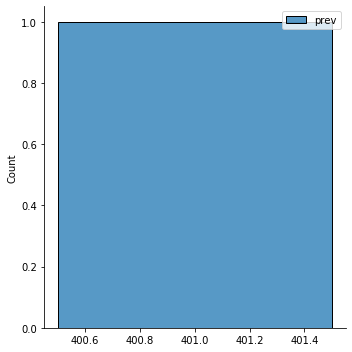

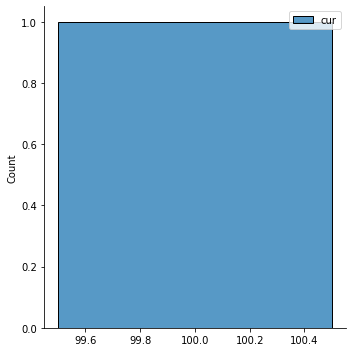

In [12]:
arr_src = []
arr_tgt = []
for src_q, tgt_q in ds_edit:
    arr_src.append(len(src_q['input_ids']))
    arr_tgt.append(len(tgt_q['input_ids']))

sns.displot(arr_src, label='prev');
plt.legend();
sns.displot(arr_tgt, label='cur');
plt.legend();

## Learning

In [13]:
CONFIG.batch_size = 8
CONFIG.final_src_max_len = 800
CONFIG.final_tgt_max_len = 500
loaders = {
    'train': torch.utils.data.DataLoader(ds_edit, 
                                         batch_size=CONFIG.batch_size,
                                         collate_fn=lambda x: EditDataset.collate_fn(x, tokenizer, CONFIG),
                                         num_workers=4, shuffle=True),
    'valid': torch.utils.data.DataLoader(ds_val, 
                                         batch_size=CONFIG.batch_size,
                                         collate_fn=lambda x: EditDataset.collate_fn(x, tokenizer, CONFIG),
                                         num_workers=4, shuffle=True)
}

In [16]:
class EditModel(nn.Module):
    def __init__(self, pretrained, config):
        super(EditModel, self).__init__()
        self.pretrained = pretrained
        

    def forward(self, x):
        src, tgt = x
        
        tgt[tgt == 0] == -100
        
        loss = self.pretrained(
            input_ids = src,
            attention_mask = (src != 0).float(),
            labels=tgt,
        ).loss
        return loss
    
    
class Criterion(nn.Module):
    def __init__(self):
        super(Criterion, self).__init__()
        
    def forward(self, pred, tgt):
        return pred

In [17]:
model = EditModel(
    T5ForConditionalGeneration.from_pretrained(CONFIG.pretrained),
    CONFIG
)
CONFIG.optimizer = 'Adam(lr=0.0001)'
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

CONFIG.name = f'{CONFIG.pretrained}_test_one_object'
CONFIG.description = f'{CONFIG.name} p(comment, x_t+1 | x_t, doc)'
CONFIG.group = "wiki_edit_test"

In [18]:
!rm -rf ./models/"{CONFIG.description}"

In [19]:
import torch
import catalyst

from catalyst.core import IRunner
from catalyst.metrics._additive import AdditiveMetric
from catalyst.callbacks.metric import BatchMetricCallback, ICallbackBatchMetric


class ExactMatchMetric(ICallbackBatchMetric):
    def __init__(self, topk, compute_on_call=False):
        super().__init__(compute_on_call=compute_on_call, prefix='', suffix='')
        self.metric_name = 'exact_match'
        self.topk = topk
        self.metrics: List[AdditiveMetric] = [
            AdditiveMetric(compute_on_call=compute_on_call) for _ in range(len(self.topk))]

    def reset(self) -> None:
        for metric in self.metrics:
            metric.reset()

    def update(self, values, n_samples):
        for value, metric in zip(values, self.metrics):
            metric.update(value, n_samples)
        return values

    def update_key_value(self, values, n_samples):
        values = self.update(values, n_samples)
        output = {
            f"{self.prefix}{self.metric_name}{key:02d}{self.suffix}": round(value, 6)
            for key, value in zip(self.topk, values)
        }
        return output

    def compute(self):
        means, stds = zip(*(metric.compute() for metric in self.metrics))
        return means, stds

    def compute_key_value(self):
        means, stds = self.compute()
        output_mean = {
            f"{self.prefix}{self.metric_name}{key:02d}{self.suffix}": round(value, 6)
            for key, value in zip(self.topk, means)
        }
        output_std = {
            f"{self.prefix}{self.metric_name}{key:02d}{self.suffix}/std": round(value, 6)
            for key, value in zip(self.topk, stds)
        }
        return {**output_mean, **output_std}


class ExactMatchCallback(BatchMetricCallback):

    def __init__(self, beam_size):
        super().__init__(
            metric= ExactMatchMetric((1,beam_size)) if beam_size > 1 else ExactMatchMetric((1,)),
            input_key='features', target_key='targets', log_on_batch=True)
        self.beam_size = beam_size

    def on_batch_end(self, runner: "IRunner") -> None:

        if runner.loader_key == 'train':
            runner.model.train()
        elif runner.loader_key.startswith('valid'):
            runner.model.eval()

            src = runner.batch['features'][0]
            tgt = runner.batch['features'][1]
            max_len = tgt.shape[1]
            with torch.no_grad():
                pred = runner.model.pretrained.generate(src.to(runner.engine.device),
                                                        attention_mask=(src != 0).float().to(runner.engine.device),
                                                        # pad_token_id=tokenizer.pad_token_id,
                                                        # bos_token_id=tokenizer.bos_token_id,
                                                        # eos_token_id=tokenizer.eos_token_id,
                                                        num_beams=self.beam_size,
                                                        num_return_sequences=self.beam_size,
                                                        max_length=max_len
                                                        )

            pred = pred[:,1:]
            pred = pred.view(-1, self.beam_size, pred.shape[1])
            acck = 0
            acc1 = 0
            for i in range(tgt.shape[0]):
                tgt_subseq = tgt[i, :pred.shape[2]].to(runner.engine.device)

                acck += float(torch.any(torch.all(tgt_subseq == pred[i], dim=1)))
                acc1 += float(torch.all(tgt_subseq == pred[i, 0]))

            acck /= len(src)
            acc1 /= len(src)

            metrics = self.metric.update_key_value([acc1, acck], len(src))

            runner.batch_metrics.update(metrics)

    def on_loader_end(self, runner: "IRunner") -> None:
        if runner.loader_key.startswith('valid'):
            metrics = self.metric.compute_key_value()
            metrics = runner.engine.mean_reduce_ddp_metrics(metrics)
            runner.loader_metrics.update(metrics)

In [20]:
CONFIG.n_epochs = 300
CONFIG.beam_size = 2

In [21]:
runner = dl.SupervisedRunner()

# CONFIG.scheduler = 'OneCycleLR(max_lr=0.005, base_momentum=0.85, max_momentum=0.95, div_factor=10.0)'

wandb_logger = dl.WandbLogger(project="interactive_lm", 
                              name=CONFIG.name, 
                              group=CONFIG.group)
# wandb_logger.log_hparams(CONFIG.__dict__)

runner.train(
    loaders=loaders,
    model=model,
    criterion=Criterion(),
    optimizer=optimizer,
#     scheduler=torch.optim.lr_scheduler.OneCycleLR(optimizer, 0.005, 
#                                                   total_steps=CONFIG.n_epochs*len(loaders_pattern['train']), 
#                                                   base_momentum=0.85, max_momentum=0.95, div_factor=10.0),
    num_epochs=CONFIG.n_epochs,
    callbacks=[
        # dl.EarlyStoppingCallback(loader_key='valid', metric_key='exact_match02', minimize=False, patience=5),
        ExactMatchCallback(beam_size=CONFIG.beam_size),
    ],
    loggers={'wandb': wandb_logger},
    logdir=f'./models/{CONFIG.description}',
    valid_loader='valid',
    valid_metric='loss',
    minimize_valid_metric=True,
    verbose=True,
#     check=True,
#     cpu=True,
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jdev8 (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.13.5 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


1/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (1/300) loss: 1.4894130229949951 | loss/mean: 1.4894130229949951 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


1/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (1/300) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match02: 0.0 | exact_match02/std: 0.0 | loss: 1.1644688844680786 | loss/mean: 1.1644688844680786 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (1/300) 


2/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (2/300) loss: 1.2743356227874756 | loss/mean: 1.2743356227874756 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


2/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (2/300) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match02: 0.0 | exact_match02/std: 0.0 | loss: 1.094394564628601 | loss/mean: 1.094394564628601 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (2/300) 


3/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (3/300) loss: 1.3296546936035156 | loss/mean: 1.3296546936035156 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


3/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (3/300) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match02: 0.0 | exact_match02/std: 0.0 | loss: 1.0174541473388672 | loss/mean: 1.0174541473388672 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (3/300) 


4/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (4/300) loss: 1.0378817319869995 | loss/mean: 1.0378817319869995 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


4/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (4/300) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match02: 0.0 | exact_match02/std: 0.0 | loss: 0.9263269901275635 | loss/mean: 0.9263269901275635 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (4/300) 


5/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (5/300) loss: 1.1769911050796509 | loss/mean: 1.1769911050796509 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


5/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (5/300) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match02: 0.0 | exact_match02/std: 0.0 | loss: 0.8229784369468689 | loss/mean: 0.8229784369468689 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (5/300) 


6/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (6/300) loss: 1.0093927383422852 | loss/mean: 1.0093927383422852 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


6/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (6/300) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match02: 0.0 | exact_match02/std: 0.0 | loss: 0.7368474006652832 | loss/mean: 0.7368474006652832 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (6/300) 


7/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (7/300) loss: 0.8864843845367432 | loss/mean: 0.8864843845367432 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


7/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (7/300) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match02: 0.0 | exact_match02/std: 0.0 | loss: 0.6704879999160767 | loss/mean: 0.6704879999160767 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (7/300) 


8/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (8/300) loss: 0.846189022064209 | loss/mean: 0.846189022064209 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


8/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (8/300) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match02: 0.0 | exact_match02/std: 0.0 | loss: 0.6206017136573792 | loss/mean: 0.6206017136573792 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (8/300) 


9/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (9/300) loss: 0.8253238201141357 | loss/mean: 0.8253238201141357 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


9/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (9/300) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match02: 0.0 | exact_match02/std: 0.0 | loss: 0.586393415927887 | loss/mean: 0.586393415927887 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (9/300) 


10/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (10/300) loss: 0.6793018579483032 | loss/mean: 0.6793018579483032 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


10/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (10/300) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match02: 0.0 | exact_match02/std: 0.0 | loss: 0.5539495944976807 | loss/mean: 0.5539495944976807 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (10/300) 


11/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (11/300) loss: 0.5879976153373718 | loss/mean: 0.5879976153373718 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


11/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (11/300) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match02: 0.0 | exact_match02/std: 0.0 | loss: 0.5224945545196533 | loss/mean: 0.5224945545196533 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (11/300) 


12/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (12/300) loss: 0.6565902829170227 | loss/mean: 0.6565902829170227 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


12/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (12/300) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match02: 0.0 | exact_match02/std: 0.0 | loss: 0.4955597221851349 | loss/mean: 0.4955597221851349 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (12/300) 


13/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (13/300) loss: 0.6130516529083252 | loss/mean: 0.6130516529083252 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


13/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (13/300) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match02: 0.0 | exact_match02/std: 0.0 | loss: 0.4733516573905945 | loss/mean: 0.4733516573905945 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (13/300) 


14/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (14/300) loss: 0.591317892074585 | loss/mean: 0.591317892074585 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


14/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (14/300) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match02: 0.0 | exact_match02/std: 0.0 | loss: 0.4486451745033264 | loss/mean: 0.4486451745033264 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (14/300) 


15/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (15/300) loss: 0.5491901636123657 | loss/mean: 0.5491901636123657 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


15/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (15/300) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match02: 0.0 | exact_match02/std: 0.0 | loss: 0.4245300590991974 | loss/mean: 0.4245300590991974 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (15/300) 


16/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (16/300) loss: 0.4420647919178009 | loss/mean: 0.4420647919178009 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


16/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (16/300) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match02: 0.0 | exact_match02/std: 0.0 | loss: 0.4023236036300659 | loss/mean: 0.4023236036300659 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (16/300) 


17/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (17/300) loss: 0.5356690287590027 | loss/mean: 0.5356690287590027 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


17/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (17/300) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match02: 0.0 | exact_match02/std: 0.0 | loss: 0.3829488456249237 | loss/mean: 0.3829488456249237 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (17/300) 


18/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (18/300) loss: 0.4656733274459839 | loss/mean: 0.4656733274459839 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


18/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (18/300) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match02: 0.0 | exact_match02/std: 0.0 | loss: 0.3658360540866852 | loss/mean: 0.3658360540866852 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (18/300) 


19/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (19/300) loss: 0.5071709752082825 | loss/mean: 0.5071709752082825 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


19/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (19/300) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match02: 0.0 | exact_match02/std: 0.0 | loss: 0.348858118057251 | loss/mean: 0.348858118057251 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (19/300) 


20/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (20/300) loss: 0.37855565547943115 | loss/mean: 0.37855565547943115 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


20/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (20/300) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match02: 0.0 | exact_match02/std: 0.0 | loss: 0.33264702558517456 | loss/mean: 0.33264702558517456 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (20/300) 


21/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (21/300) loss: 0.41226986050605774 | loss/mean: 0.41226986050605774 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


21/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (21/300) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match02: 0.0 | exact_match02/std: 0.0 | loss: 0.31645405292510986 | loss/mean: 0.31645405292510986 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (21/300) 


22/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (22/300) loss: 0.40348780155181885 | loss/mean: 0.40348780155181885 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


22/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (22/300) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match02: 0.0 | exact_match02/std: 0.0 | loss: 0.30132928490638733 | loss/mean: 0.30132928490638733 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (22/300) 


23/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (23/300) loss: 0.386972576379776 | loss/mean: 0.386972576379776 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


23/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (23/300) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match02: 0.0 | exact_match02/std: 0.0 | loss: 0.285183846950531 | loss/mean: 0.285183846950531 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (23/300) 


24/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (24/300) loss: 0.41396716237068176 | loss/mean: 0.41396716237068176 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


24/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (24/300) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match02: 0.0 | exact_match02/std: 0.0 | loss: 0.2691819667816162 | loss/mean: 0.2691819667816162 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (24/300) 


25/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (25/300) loss: 0.35884830355644226 | loss/mean: 0.35884830355644226 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


25/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (25/300) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match02: 0.0 | exact_match02/std: 0.0 | loss: 0.25428134202957153 | loss/mean: 0.25428134202957153 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (25/300) 


26/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (26/300) loss: 0.3400762677192688 | loss/mean: 0.3400762677192688 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


26/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (26/300) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match02: 0.0 | exact_match02/std: 0.0 | loss: 0.2428077757358551 | loss/mean: 0.2428077757358551 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (26/300) 


27/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (27/300) loss: 0.30314332246780396 | loss/mean: 0.30314332246780396 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


27/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (27/300) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match02: 0.0 | exact_match02/std: 0.0 | loss: 0.2326303869485855 | loss/mean: 0.2326303869485855 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (27/300) 


28/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (28/300) loss: 0.4104669690132141 | loss/mean: 0.4104669690132141 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


28/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (28/300) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match02: 0.0 | exact_match02/std: 0.0 | loss: 0.22316224873065948 | loss/mean: 0.22316224873065948 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (28/300) 


29/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (29/300) loss: 0.27313199639320374 | loss/mean: 0.27313199639320374 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


29/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (29/300) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match02: 0.0 | exact_match02/std: 0.0 | loss: 0.21412000060081482 | loss/mean: 0.21412000060081482 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (29/300) 


30/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (30/300) loss: 0.2952651083469391 | loss/mean: 0.2952651083469391 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


30/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (30/300) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match02: 0.0 | exact_match02/std: 0.0 | loss: 0.20577217638492584 | loss/mean: 0.20577217638492584 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (30/300) 


31/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (31/300) loss: 0.3053111135959625 | loss/mean: 0.3053111135959625 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


31/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (31/300) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match02: 0.0 | exact_match02/std: 0.0 | loss: 0.19855527579784393 | loss/mean: 0.19855527579784393 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (31/300) 


32/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (32/300) loss: 0.23993541300296783 | loss/mean: 0.23993541300296783 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


32/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (32/300) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match02: 0.0 | exact_match02/std: 0.0 | loss: 0.19158095121383667 | loss/mean: 0.19158095121383667 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (32/300) 


33/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (33/300) loss: 0.2878294587135315 | loss/mean: 0.2878294587135315 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


33/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (33/300) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match02: 0.0 | exact_match02/std: 0.0 | loss: 0.1848086565732956 | loss/mean: 0.1848086565732956 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (33/300) 


34/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (34/300) loss: 0.23721714317798615 | loss/mean: 0.23721714317798615 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


34/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (34/300) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match02: 0.0 | exact_match02/std: 0.0 | loss: 0.17527443170547485 | loss/mean: 0.17527443170547485 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (34/300) 


35/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (35/300) loss: 0.18654046952724457 | loss/mean: 0.18654046952724457 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


35/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (35/300) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match02: 0.0 | exact_match02/std: 0.0 | loss: 0.16483592987060547 | loss/mean: 0.16483592987060547 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (35/300) 


36/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (36/300) loss: 0.21546225249767303 | loss/mean: 0.21546225249767303 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


36/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (36/300) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match02: 0.0 | exact_match02/std: 0.0 | loss: 0.15346570312976837 | loss/mean: 0.15346570312976837 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (36/300) 


37/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (37/300) loss: 0.22260551154613495 | loss/mean: 0.22260551154613495 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


37/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (37/300) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match02: 0.0 | exact_match02/std: 0.0 | loss: 0.1428387314081192 | loss/mean: 0.1428387314081192 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (37/300) 


38/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (38/300) loss: 0.1886385679244995 | loss/mean: 0.1886385679244995 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


38/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (38/300) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match02: 0.0 | exact_match02/std: 0.0 | loss: 0.1314738243818283 | loss/mean: 0.1314738243818283 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (38/300) 


39/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (39/300) loss: 0.18921911716461182 | loss/mean: 0.18921911716461182 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


39/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (39/300) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match02: 0.0 | exact_match02/std: 0.0 | loss: 0.11940126121044159 | loss/mean: 0.11940126121044159 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (39/300) 


40/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (40/300) loss: 0.16778446733951569 | loss/mean: 0.16778446733951569 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


40/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (40/300) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match02: 0.0 | exact_match02/std: 0.0 | loss: 0.1075574979186058 | loss/mean: 0.1075574979186058 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (40/300) 


41/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (41/300) loss: 0.1606207638978958 | loss/mean: 0.1606207638978958 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


41/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (41/300) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match02: 0.0 | exact_match02/std: 0.0 | loss: 0.0955454409122467 | loss/mean: 0.0955454409122467 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (41/300) 


42/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (42/300) loss: 0.1444275677204132 | loss/mean: 0.1444275677204132 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


42/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (42/300) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match02: 0.0 | exact_match02/std: 0.0 | loss: 0.08372551947832108 | loss/mean: 0.08372551947832108 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (42/300) 


43/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (43/300) loss: 0.15800970792770386 | loss/mean: 0.15800970792770386 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


43/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (43/300) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match02: 0.0 | exact_match02/std: 0.0 | loss: 0.0732349082827568 | loss/mean: 0.0732349082827568 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (43/300) 


44/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (44/300) loss: 0.11528615653514862 | loss/mean: 0.11528615653514862 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


44/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (44/300) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match02: 0.0 | exact_match02/std: 0.0 | loss: 0.06357399374246597 | loss/mean: 0.06357399374246597 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (44/300) 


45/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (45/300) loss: 0.17410890758037567 | loss/mean: 0.17410890758037567 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


45/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (45/300) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match02: 0.0 | exact_match02/std: 0.0 | loss: 0.05447772517800331 | loss/mean: 0.05447772517800331 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (45/300) 


46/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (46/300) loss: 0.115211620926857 | loss/mean: 0.115211620926857 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


46/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (46/300) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match02: 0.0 | exact_match02/std: 0.0 | loss: 0.047024961560964584 | loss/mean: 0.047024961560964584 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (46/300) 


47/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (47/300) loss: 0.12223216891288757 | loss/mean: 0.12223216891288757 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


47/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (47/300) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match02: 0.0 | exact_match02/std: 0.0 | loss: 0.040320731699466705 | loss/mean: 0.040320731699466705 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (47/300) 


48/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (48/300) loss: 0.1276240050792694 | loss/mean: 0.1276240050792694 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


48/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (48/300) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match02: 0.0 | exact_match02/std: 0.0 | loss: 0.03575798124074936 | loss/mean: 0.03575798124074936 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (48/300) 


49/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (49/300) loss: 0.1385425329208374 | loss/mean: 0.1385425329208374 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


49/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (49/300) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match02: 0.0 | exact_match02/std: 0.0 | loss: 0.03033764846622944 | loss/mean: 0.03033764846622944 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (49/300) 


50/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (50/300) loss: 0.1283731907606125 | loss/mean: 0.1283731907606125 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


50/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (50/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.02639188803732395 | loss/mean: 0.02639188803732395 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (50/300) 


51/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (51/300) loss: 0.07780690491199493 | loss/mean: 0.07780690491199493 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


51/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (51/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.02245393767952919 | loss/mean: 0.02245393767952919 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (51/300) 


52/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (52/300) loss: 0.11915400624275208 | loss/mean: 0.11915400624275208 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


52/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (52/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.018561819568276405 | loss/mean: 0.018561819568276405 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (52/300) 


53/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (53/300) loss: 0.03417093679308891 | loss/mean: 0.03417093679308891 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


53/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (53/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.015366734005510807 | loss/mean: 0.015366734005510807 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (53/300) 


54/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (54/300) loss: 0.06237839534878731 | loss/mean: 0.06237839534878731 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


54/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (54/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.012447360903024673 | loss/mean: 0.012447360903024673 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (54/300) 


55/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (55/300) loss: 0.07352551072835922 | loss/mean: 0.07352551072835922 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


55/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (55/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.010285258293151855 | loss/mean: 0.010285258293151855 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (55/300) 


56/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (56/300) loss: 0.04839519411325455 | loss/mean: 0.04839519411325455 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


56/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (56/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.00803880300372839 | loss/mean: 0.00803880300372839 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (56/300) 


57/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (57/300) loss: 0.03859131038188934 | loss/mean: 0.03859131038188934 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


57/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (57/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.006530093494802713 | loss/mean: 0.006530093494802713 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (57/300) 


58/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (58/300) loss: 0.032210856676101685 | loss/mean: 0.032210856676101685 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


58/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (58/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.005235742777585983 | loss/mean: 0.005235742777585983 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (58/300) 


59/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (59/300) loss: 0.0492352694272995 | loss/mean: 0.0492352694272995 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


59/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (59/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.004178998991847038 | loss/mean: 0.004178998991847038 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (59/300) 


60/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (60/300) loss: 0.027791406959295273 | loss/mean: 0.027791406959295273 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


60/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (60/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.003436747705563903 | loss/mean: 0.003436747705563903 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (60/300) 


61/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (61/300) loss: 0.02961169183254242 | loss/mean: 0.02961169183254242 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


61/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (61/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.002899765269830823 | loss/mean: 0.002899765269830823 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (61/300) 


62/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (62/300) loss: 0.023670369759202003 | loss/mean: 0.023670369759202003 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


62/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (62/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.002355748089030385 | loss/mean: 0.002355748089030385 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (62/300) 


63/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (63/300) loss: 0.041721634566783905 | loss/mean: 0.041721634566783905 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


63/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (63/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.0019353805109858513 | loss/mean: 0.0019353805109858513 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (63/300) 


64/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (64/300) loss: 0.14527295529842377 | loss/mean: 0.14527295529842377 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


64/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (64/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.00162700901273638 | loss/mean: 0.00162700901273638 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (64/300) 


65/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (65/300) loss: 0.03419259563088417 | loss/mean: 0.03419259563088417 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


65/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (65/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.0014000365044921637 | loss/mean: 0.0014000365044921637 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (65/300) 


66/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (66/300) loss: 0.059325069189071655 | loss/mean: 0.059325069189071655 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


66/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (66/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.0012213137233629823 | loss/mean: 0.0012213137233629823 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (66/300) 


67/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (67/300) loss: 0.025595853105187416 | loss/mean: 0.025595853105187416 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


67/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (67/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.001105206785723567 | loss/mean: 0.001105206785723567 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (67/300) 


68/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (68/300) loss: 0.01683030277490616 | loss/mean: 0.01683030277490616 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


68/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (68/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.001003141631372273 | loss/mean: 0.001003141631372273 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (68/300) 


69/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (69/300) loss: 0.030041612684726715 | loss/mean: 0.030041612684726715 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


69/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (69/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.0009079657029360533 | loss/mean: 0.0009079657029360533 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (69/300) 


70/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (70/300) loss: 0.024693498387932777 | loss/mean: 0.024693498387932777 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


70/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (70/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.0008376804762519896 | loss/mean: 0.0008376804762519896 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (70/300) 


71/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (71/300) loss: 0.01401436049491167 | loss/mean: 0.01401436049491167 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


71/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (71/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.000778080546297133 | loss/mean: 0.000778080546297133 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (71/300) 


72/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (72/300) loss: 0.013613156042993069 | loss/mean: 0.013613156042993069 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


72/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (72/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.000729859690181911 | loss/mean: 0.000729859690181911 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (72/300) 


73/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (73/300) loss: 0.038921549916267395 | loss/mean: 0.038921549916267395 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


73/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (73/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.000707605155184865 | loss/mean: 0.000707605155184865 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (73/300) 


74/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (74/300) loss: 0.017152931541204453 | loss/mean: 0.017152931541204453 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


74/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (74/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.0006899889558553696 | loss/mean: 0.0006899889558553696 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (74/300) 


75/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (75/300) loss: 0.009906310588121414 | loss/mean: 0.009906310588121414 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


75/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (75/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.0006750529282726347 | loss/mean: 0.0006750529282726347 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (75/300) 


76/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (76/300) loss: 0.010132857598364353 | loss/mean: 0.010132857598364353 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


76/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (76/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.0006591501878574491 | loss/mean: 0.0006591501878574491 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (76/300) 


77/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (77/300) loss: 0.010489940643310547 | loss/mean: 0.010489940643310547 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


77/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (77/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.0006413666415028274 | loss/mean: 0.0006413666415028274 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (77/300) 


78/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (78/300) loss: 0.012837606482207775 | loss/mean: 0.012837606482207775 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


78/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (78/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.0006320508546195924 | loss/mean: 0.0006320508546195924 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (78/300) 


79/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (79/300) loss: 0.01006144005805254 | loss/mean: 0.01006144005805254 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


79/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (79/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.0006168998661451042 | loss/mean: 0.0006168998661451042 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (79/300) 


80/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (80/300) loss: 0.018189458176493645 | loss/mean: 0.018189458176493645 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


80/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (80/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.0005853473558090627 | loss/mean: 0.0005853473558090627 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (80/300) 


81/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (81/300) loss: 0.007292391266673803 | loss/mean: 0.007292391266673803 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


81/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (81/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.0005596040282398462 | loss/mean: 0.0005596040282398462 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (81/300) 


82/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (82/300) loss: 0.006994426250457764 | loss/mean: 0.006994426250457764 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


82/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (82/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.000535767525434494 | loss/mean: 0.000535767525434494 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (82/300) 


83/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (83/300) loss: 0.006848483812063932 | loss/mean: 0.006848483812063932 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


83/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (83/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.0005143707967363298 | loss/mean: 0.0005143707967363298 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (83/300) 


84/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (84/300) loss: 0.009453557431697845 | loss/mean: 0.009453557431697845 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


84/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (84/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.0004962427774444222 | loss/mean: 0.0004962427774444222 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (84/300) 


85/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (85/300) loss: 0.004553212318569422 | loss/mean: 0.004553212318569422 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


85/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (85/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.0004805911739822477 | loss/mean: 0.0004805911739822477 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (85/300) 


86/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (86/300) loss: 0.011565013788640499 | loss/mean: 0.011565013788640499 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


86/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (86/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.0004631653428077698 | loss/mean: 0.0004631653428077698 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (86/300) 


87/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (87/300) loss: 0.0054327319376170635 | loss/mean: 0.0054327319376170635 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


87/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (87/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.00044804360368289053 | loss/mean: 0.00044804360368289053 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (87/300) 


88/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (88/300) loss: 0.012007394805550575 | loss/mean: 0.012007394805550575 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


88/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (88/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.0004332720418460667 | loss/mean: 0.0004332720418460667 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (88/300) 


89/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (89/300) loss: 0.007499122992157936 | loss/mean: 0.007499122992157936 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


89/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (89/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.00042034167563542724 | loss/mean: 0.00042034167563542724 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (89/300) 


90/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (90/300) loss: 0.010773944668471813 | loss/mean: 0.010773944668471813 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


90/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (90/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.00040794932283461094 | loss/mean: 0.00040794932283461094 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (90/300) 


91/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (91/300) loss: 0.00541197182610631 | loss/mean: 0.00541197182610631 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


91/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (91/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.0003970880061388016 | loss/mean: 0.0003970880061388016 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (91/300) 


92/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (92/300) loss: 0.008546005934476852 | loss/mean: 0.008546005934476852 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


92/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (92/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.0003867621999233961 | loss/mean: 0.0003867621999233961 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (92/300) 


93/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (93/300) loss: 0.015732061117887497 | loss/mean: 0.015732061117887497 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


93/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (93/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.00037748258910141885 | loss/mean: 0.00037748258910141885 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (93/300) 


94/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (94/300) loss: 0.004459071438759565 | loss/mean: 0.004459071438759565 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


94/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (94/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.00036853214260190725 | loss/mean: 0.00036853214260190725 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (94/300) 


95/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (95/300) loss: 0.009962543845176697 | loss/mean: 0.009962543845176697 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


95/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (95/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.0003616187022998929 | loss/mean: 0.0003616187022998929 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (95/300) 


96/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (96/300) loss: 0.011746878735721111 | loss/mean: 0.011746878735721111 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


96/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (96/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.00035493483301252127 | loss/mean: 0.00035493483301252127 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (96/300) 


97/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (97/300) loss: 0.004544677212834358 | loss/mean: 0.004544677212834358 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


97/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (97/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.00034925027284771204 | loss/mean: 0.00034925027284771204 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (97/300) 


98/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (98/300) loss: 0.006693558301776648 | loss/mean: 0.006693558301776648 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


98/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (98/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.0003441088192630559 | loss/mean: 0.0003441088192630559 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (98/300) 


99/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (99/300) loss: 0.003810842288658023 | loss/mean: 0.003810842288658023 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


99/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (99/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.0003383192524779588 | loss/mean: 0.0003383192524779588 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (99/300) 


100/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (100/300) loss: 0.014848893508315086 | loss/mean: 0.014848893508315086 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


100/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (100/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.00032565559376962483 | loss/mean: 0.00032565559376962483 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (100/300) 


101/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (101/300) loss: 0.004988109692931175 | loss/mean: 0.004988109692931175 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


101/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (101/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.0003144956426694989 | loss/mean: 0.0003144956426694989 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (101/300) 


102/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (102/300) loss: 0.005158454179763794 | loss/mean: 0.005158454179763794 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


102/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (102/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.0003043058968614787 | loss/mean: 0.0003043058968614787 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (102/300) 


103/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (103/300) loss: 0.009316940791904926 | loss/mean: 0.009316940791904926 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


103/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (103/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.0002947413013316691 | loss/mean: 0.0002947413013316691 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (103/300) 


104/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (104/300) loss: 0.004096293356269598 | loss/mean: 0.004096293356269598 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


104/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (104/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.0002864179841708392 | loss/mean: 0.0002864179841708392 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (104/300) 


105/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (105/300) loss: 0.005525423213839531 | loss/mean: 0.005525423213839531 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


105/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (105/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.0002786794793792069 | loss/mean: 0.0002786794793792069 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (105/300) 


106/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (106/300) loss: 0.007044053170830011 | loss/mean: 0.007044053170830011 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


106/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (106/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.0002677705488167703 | loss/mean: 0.0002677705488167703 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (106/300) 


107/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (107/300) loss: 0.00588212488219142 | loss/mean: 0.00588212488219142 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


107/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (107/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.0002576956176199019 | loss/mean: 0.0002576956176199019 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (107/300) 


108/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (108/300) loss: 0.003925005439668894 | loss/mean: 0.003925005439668894 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


108/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (108/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.0002488990139681846 | loss/mean: 0.0002488990139681846 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (108/300) 


109/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (109/300) loss: 0.00393840204924345 | loss/mean: 0.00393840204924345 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


109/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (109/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.00024114156258292496 | loss/mean: 0.00024114156258292496 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (109/300) 


110/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (110/300) loss: 0.010397534817457199 | loss/mean: 0.010397534817457199 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


110/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (110/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.00023288412194233388 | loss/mean: 0.00023288412194233388 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (110/300) 


111/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (111/300) loss: 0.0033212737180292606 | loss/mean: 0.0033212737180292606 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


111/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (111/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.00022526425891555846 | loss/mean: 0.00022526425891555846 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (111/300) 


112/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (112/300) loss: 0.0034596065524965525 | loss/mean: 0.0034596065524965525 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


112/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (112/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.0002179654111387208 | loss/mean: 0.0002179654111387208 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (112/300) 


113/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (113/300) loss: 0.003886002115905285 | loss/mean: 0.003886002115905285 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


113/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (113/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.00021160506003070623 | loss/mean: 0.00021160506003070623 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (113/300) 


114/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (114/300) loss: 0.005447946023195982 | loss/mean: 0.005447946023195982 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


114/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (114/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.00020543270511552691 | loss/mean: 0.00020543270511552691 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (114/300) 


115/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (115/300) loss: 0.022367918863892555 | loss/mean: 0.022367918863892555 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


115/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (115/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.00020145719463471323 | loss/mean: 0.00020145719463471323 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (115/300) 


116/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (116/300) loss: 0.002392110414803028 | loss/mean: 0.002392110414803028 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


116/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (116/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.0001980080851353705 | loss/mean: 0.0001980080851353705 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (116/300) 


117/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (117/300) loss: 0.0040023960173130035 | loss/mean: 0.0040023960173130035 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


117/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (117/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.0001949746219906956 | loss/mean: 0.0001949746219906956 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (117/300) 


118/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (118/300) loss: 0.004291113466024399 | loss/mean: 0.004291113466024399 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


118/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (118/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.00019225224968977273 | loss/mean: 0.00019225224968977273 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (118/300) 


119/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (119/300) loss: 0.003109685843810439 | loss/mean: 0.003109685843810439 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


119/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (119/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.00018973430269397795 | loss/mean: 0.00018973430269397795 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (119/300) 


120/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (120/300) loss: 0.00381873338483274 | loss/mean: 0.00381873338483274 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


120/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (120/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.00018730867304839194 | loss/mean: 0.00018730867304839194 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (120/300) 


121/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (121/300) loss: 0.0034808337222784758 | loss/mean: 0.0034808337222784758 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


121/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (121/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.00018479826394468546 | loss/mean: 0.00018479826394468546 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (121/300) 


122/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (122/300) loss: 0.00834336131811142 | loss/mean: 0.00834336131811142 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


122/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (122/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.00018183230713475496 | loss/mean: 0.00018183230713475496 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (122/300) 


123/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (123/300) loss: 0.0021559896413236856 | loss/mean: 0.0021559896413236856 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


123/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (123/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.0001788272347766906 | loss/mean: 0.0001788272347766906 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (123/300) 


124/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (124/300) loss: 0.002214025938883424 | loss/mean: 0.002214025938883424 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


124/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (124/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.00017600407591089606 | loss/mean: 0.00017600407591089606 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (124/300) 


125/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (125/300) loss: 0.009912203997373581 | loss/mean: 0.009912203997373581 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


125/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (125/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.00017312528507318348 | loss/mean: 0.00017312528507318348 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (125/300) 


126/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (126/300) loss: 0.0037728778552263975 | loss/mean: 0.0037728778552263975 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


126/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (126/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.00017039735394064337 | loss/mean: 0.00017039735394064337 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (126/300) 


127/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (127/300) loss: 0.019320793449878693 | loss/mean: 0.019320793449878693 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


127/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (127/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.00016634799249004573 | loss/mean: 0.00016634799249004573 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (127/300) 


128/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (128/300) loss: 0.001983440713956952 | loss/mean: 0.001983440713956952 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


128/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (128/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.0001632716739550233 | loss/mean: 0.0001632716739550233 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (128/300) 


129/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (129/300) loss: 0.007865925319492817 | loss/mean: 0.007865925319492817 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


129/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (129/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.0001614633947610855 | loss/mean: 0.0001614633947610855 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (129/300) 


130/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (130/300) loss: 0.005448917858302593 | loss/mean: 0.005448917858302593 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


130/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (130/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.00016029317339416593 | loss/mean: 0.00016029317339416593 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (130/300) 


131/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (131/300) loss: 0.0027552463579922915 | loss/mean: 0.0027552463579922915 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


131/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (131/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.0001594871428096667 | loss/mean: 0.0001594871428096667 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (131/300) 


132/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (132/300) loss: 0.009185422211885452 | loss/mean: 0.009185422211885452 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


132/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (132/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.0001582786935614422 | loss/mean: 0.0001582786935614422 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (132/300) 


133/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (133/300) loss: 0.026298167183995247 | loss/mean: 0.026298167183995247 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


133/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (133/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.000158447161084041 | loss/mean: 0.000158447161084041 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (133/300) 


134/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (134/300) loss: 0.07051749527454376 | loss/mean: 0.07051749527454376 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


134/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (134/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.00015677482588216662 | loss/mean: 0.00015677482588216662 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (134/300) 


135/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (135/300) loss: 0.003513728966936469 | loss/mean: 0.003513728966936469 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


135/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (135/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.0001554262125864625 | loss/mean: 0.0001554262125864625 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (135/300) 


136/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (136/300) loss: 0.008463045582175255 | loss/mean: 0.008463045582175255 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


136/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (136/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.00015589900431223214 | loss/mean: 0.00015589900431223214 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (136/300) 


137/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (137/300) loss: 0.00316429790109396 | loss/mean: 0.00316429790109396 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


137/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (137/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.0001564929261803627 | loss/mean: 0.0001564929261803627 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (137/300) 


138/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (138/300) loss: 0.004712707828730345 | loss/mean: 0.004712707828730345 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


138/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (138/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.00015728993457742035 | loss/mean: 0.00015728993457742035 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (138/300) 


139/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (139/300) loss: 0.002990612993016839 | loss/mean: 0.002990612993016839 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


139/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (139/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.00015830207848921418 | loss/mean: 0.00015830207848921418 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (139/300) 


140/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (140/300) loss: 0.0031863031908869743 | loss/mean: 0.0031863031908869743 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


140/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (140/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.00015938543947413564 | loss/mean: 0.00015938543947413564 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (140/300) 


141/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (141/300) loss: 0.0034816444385796785 | loss/mean: 0.0034816444385796785 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


141/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (141/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.00016041599155869335 | loss/mean: 0.00016041599155869335 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (141/300) 


142/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (142/300) loss: 0.0018037420231848955 | loss/mean: 0.0018037420231848955 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


142/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (142/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.0001613404747331515 | loss/mean: 0.0001613404747331515 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (142/300) 


143/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (143/300) loss: 0.002633832162246108 | loss/mean: 0.002633832162246108 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


143/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (143/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.0001620742114027962 | loss/mean: 0.0001620742114027962 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (143/300) 


144/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (144/300) loss: 0.003934528678655624 | loss/mean: 0.003934528678655624 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


144/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (144/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.0001625123550184071 | loss/mean: 0.0001625123550184071 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (144/300) 


145/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (145/300) loss: 0.002860402222722769 | loss/mean: 0.002860402222722769 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


145/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (145/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.0001627753663342446 | loss/mean: 0.0001627753663342446 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (145/300) 


146/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (146/300) loss: 0.014984969049692154 | loss/mean: 0.014984969049692154 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


146/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (146/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.00016318858251906931 | loss/mean: 0.00016318858251906931 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (146/300) 


147/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (147/300) loss: 0.006418698467314243 | loss/mean: 0.006418698467314243 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


147/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (147/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.0001630656624911353 | loss/mean: 0.0001630656624911353 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (147/300) 


148/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (148/300) loss: 0.008588184602558613 | loss/mean: 0.008588184602558613 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


148/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (148/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.0001626727171242237 | loss/mean: 0.0001626727171242237 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (148/300) 


149/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (149/300) loss: 0.0019576745107769966 | loss/mean: 0.0019576745107769966 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


149/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (149/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.00016181310638785362 | loss/mean: 0.00016181310638785362 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (149/300) 


150/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (150/300) loss: 0.0031417019199579954 | loss/mean: 0.0031417019199579954 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


150/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (150/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.00016088789561763406 | loss/mean: 0.00016088789561763406 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (150/300) 


151/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (151/300) loss: 0.007082171272486448 | loss/mean: 0.007082171272486448 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


151/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (151/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.00015968791558407247 | loss/mean: 0.00015968791558407247 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (151/300) 


152/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (152/300) loss: 0.004802511539310217 | loss/mean: 0.004802511539310217 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


152/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (152/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.00015822243585716933 | loss/mean: 0.00015822243585716933 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (152/300) 


153/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (153/300) loss: 0.002970883622765541 | loss/mean: 0.002970883622765541 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


153/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (153/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.00015653780428692698 | loss/mean: 0.00015653780428692698 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (153/300) 


154/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (154/300) loss: 0.061657026410102844 | loss/mean: 0.061657026410102844 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


154/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (154/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.0001529024011688307 | loss/mean: 0.0001529024011688307 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (154/300) 


155/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (155/300) loss: 0.002218896523118019 | loss/mean: 0.002218896523118019 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


155/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (155/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.00015075079863891006 | loss/mean: 0.00015075079863891006 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (155/300) 


156/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (156/300) loss: 0.0046171038411557674 | loss/mean: 0.0046171038411557674 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


156/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (156/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.00014909497986081988 | loss/mean: 0.00014909497986081988 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (156/300) 


157/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (157/300) loss: 0.004903963301330805 | loss/mean: 0.004903963301330805 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


157/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (157/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.00014826393453404307 | loss/mean: 0.00014826393453404307 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (157/300) 


158/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (158/300) loss: 0.00204942817799747 | loss/mean: 0.00204942817799747 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


158/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (158/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.00014744451618753374 | loss/mean: 0.00014744451618753374 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (158/300) 


159/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (159/300) loss: 0.0016419516177847981 | loss/mean: 0.0016419516177847981 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


159/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (159/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.0001468832924729213 | loss/mean: 0.0001468832924729213 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (159/300) 


160/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (160/300) loss: 0.014736468903720379 | loss/mean: 0.014736468903720379 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


160/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (160/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.00014658033614978194 | loss/mean: 0.00014658033614978194 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (160/300) 


161/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (161/300) loss: 0.0040144287049770355 | loss/mean: 0.0040144287049770355 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


161/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (161/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.00014631080557592213 | loss/mean: 0.00014631080557592213 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (161/300) 


162/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (162/300) loss: 0.005143329035490751 | loss/mean: 0.005143329035490751 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


162/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (162/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.00014501664554700255 | loss/mean: 0.00014501664554700255 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (162/300) 


163/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (163/300) loss: 0.012106120586395264 | loss/mean: 0.012106120586395264 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


163/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (163/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.0001437103346688673 | loss/mean: 0.0001437103346688673 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (163/300) 


164/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (164/300) loss: 0.003471833188086748 | loss/mean: 0.003471833188086748 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


164/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (164/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.00014273400302045047 | loss/mean: 0.00014273400302045047 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (164/300) 


165/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (165/300) loss: 0.005279975943267345 | loss/mean: 0.005279975943267345 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


165/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (165/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.0001417803723597899 | loss/mean: 0.0001417803723597899 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (165/300) 


166/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (166/300) loss: 0.0047793034464120865 | loss/mean: 0.0047793034464120865 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


166/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (166/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.00014089455362409353 | loss/mean: 0.00014089455362409353 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (166/300) 


167/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (167/300) loss: 0.005011165514588356 | loss/mean: 0.005011165514588356 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


167/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (167/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.00013989208673592657 | loss/mean: 0.00013989208673592657 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (167/300) 


168/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (168/300) loss: 0.005308378953486681 | loss/mean: 0.005308378953486681 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


168/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (168/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.0001387598313158378 | loss/mean: 0.0001387598313158378 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (168/300) 


169/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (169/300) loss: 0.0014435022603720427 | loss/mean: 0.0014435022603720427 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


169/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (169/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.00013771817611996084 | loss/mean: 0.00013771817611996084 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (169/300) 


170/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (170/300) loss: 0.005781114567071199 | loss/mean: 0.005781114567071199 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


170/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (170/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.00013708726328331977 | loss/mean: 0.00013708726328331977 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (170/300) 


171/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (171/300) loss: 0.006625484209507704 | loss/mean: 0.006625484209507704 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


171/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (171/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.00013633965863846242 | loss/mean: 0.00013633965863846242 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (171/300) 


172/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (172/300) loss: 0.0031184738036245108 | loss/mean: 0.0031184738036245108 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


172/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (172/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.00013592645700555295 | loss/mean: 0.00013592645700555295 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (172/300) 


173/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (173/300) loss: 0.00333111803047359 | loss/mean: 0.00333111803047359 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


173/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (173/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.00013523946108762175 | loss/mean: 0.00013523946108762175 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (173/300) 


174/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (174/300) loss: 0.0015090719098225236 | loss/mean: 0.0015090719098225236 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


174/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (174/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.00013467035023495555 | loss/mean: 0.00013467035023495555 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (174/300) 


175/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (175/300) loss: 0.0026157526299357414 | loss/mean: 0.0026157526299357414 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


175/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (175/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.0001340929011348635 | loss/mean: 0.0001340929011348635 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (175/300) 


176/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (176/300) loss: 0.007084272336214781 | loss/mean: 0.007084272336214781 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


176/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (176/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.00013313553063198924 | loss/mean: 0.00013313553063198924 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (176/300) 


177/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (177/300) loss: 0.0017736456356942654 | loss/mean: 0.0017736456356942654 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


177/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (177/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.00013211880286689848 | loss/mean: 0.00013211880286689848 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (177/300) 


178/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (178/300) loss: 0.0018532942049205303 | loss/mean: 0.0018532942049205303 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


178/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (178/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.00013096642214804888 | loss/mean: 0.00013096642214804888 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (178/300) 


179/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (179/300) loss: 0.0026178027037531137 | loss/mean: 0.0026178027037531137 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


179/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (179/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.00012965229689143598 | loss/mean: 0.00012965229689143598 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (179/300) 


180/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (180/300) loss: 0.0027471035718917847 | loss/mean: 0.0027471035718917847 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


180/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (180/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.00012836561654694378 | loss/mean: 0.00012836561654694378 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (180/300) 


181/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (181/300) loss: 0.001935866428539157 | loss/mean: 0.001935866428539157 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


181/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (181/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.0001271646615350619 | loss/mean: 0.0001271646615350619 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (181/300) 


182/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (182/300) loss: 0.0030360885430127382 | loss/mean: 0.0030360885430127382 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


182/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (182/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.00012623603106476367 | loss/mean: 0.00012623603106476367 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (182/300) 


183/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (183/300) loss: 0.003439599648118019 | loss/mean: 0.003439599648118019 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


183/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (183/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.000124971687910147 | loss/mean: 0.000124971687910147 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (183/300) 


184/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (184/300) loss: 0.005727259907871485 | loss/mean: 0.005727259907871485 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


184/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (184/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.00012305537529755384 | loss/mean: 0.00012305537529755384 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (184/300) 


185/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (185/300) loss: 0.003294978756457567 | loss/mean: 0.003294978756457567 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


185/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (185/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.00012122946645831689 | loss/mean: 0.00012122946645831689 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (185/300) 


186/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (186/300) loss: 0.012752214446663857 | loss/mean: 0.012752214446663857 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


186/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (186/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.00011989392078248784 | loss/mean: 0.00011989392078248784 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (186/300) 


187/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (187/300) loss: 0.0015031072543933988 | loss/mean: 0.0015031072543933988 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


187/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (187/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.00011861923121614382 | loss/mean: 0.00011861923121614382 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (187/300) 


188/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (188/300) loss: 0.0036574890837073326 | loss/mean: 0.0036574890837073326 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


188/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (188/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.00011752798309316859 | loss/mean: 0.00011752798309316859 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (188/300) 


189/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (189/300) loss: 0.0018351797480136156 | loss/mean: 0.0018351797480136156 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


189/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (189/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.00011647967039607465 | loss/mean: 0.00011647967039607465 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (189/300) 


190/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (190/300) loss: 0.0014276676811277866 | loss/mean: 0.0014276676811277866 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


190/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (190/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.00011540519335540012 | loss/mean: 0.00011540519335540012 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (190/300) 


191/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (191/300) loss: 0.0030719933565706015 | loss/mean: 0.0030719933565706015 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


191/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (191/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.00011330167762935162 | loss/mean: 0.00011330167762935162 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (191/300) 


192/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (192/300) loss: 0.006148466840386391 | loss/mean: 0.006148466840386391 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


192/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (192/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.00011139074194943532 | loss/mean: 0.00011139074194943532 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (192/300) 


193/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (193/300) loss: 0.002545586321502924 | loss/mean: 0.002545586321502924 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


193/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (193/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.00010955226753139868 | loss/mean: 0.00010955226753139868 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (193/300) 


194/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (194/300) loss: 0.005981749389320612 | loss/mean: 0.005981749389320612 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


194/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (194/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.00010752901289379224 | loss/mean: 0.00010752901289379224 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (194/300) 


195/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (195/300) loss: 0.0026725393254309893 | loss/mean: 0.0026725393254309893 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


195/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (195/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.00010570094309514388 | loss/mean: 0.00010570094309514388 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (195/300) 


196/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (196/300) loss: 0.0026364591903984547 | loss/mean: 0.0026364591903984547 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


196/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (196/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.00010398580343462527 | loss/mean: 0.00010398580343462527 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (196/300) 


197/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (197/300) loss: 0.002035715151578188 | loss/mean: 0.002035715151578188 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


197/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (197/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.00010224684228887782 | loss/mean: 0.00010224684228887782 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (197/300) 


198/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (198/300) loss: 0.0013746549375355244 | loss/mean: 0.0013746549375355244 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


198/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (198/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.0001005710000754334 | loss/mean: 0.0001005710000754334 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (198/300) 


199/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (199/300) loss: 0.0013006237568333745 | loss/mean: 0.0013006237568333745 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


199/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (199/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 9.896417759591714e-05 | loss/mean: 9.896417759591714e-05 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (199/300) 


200/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (200/300) loss: 0.002213324187323451 | loss/mean: 0.002213324187323451 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


200/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (200/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 9.737048094393685e-05 | loss/mean: 9.737048094393685e-05 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (200/300) 


201/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (201/300) loss: 0.02262766845524311 | loss/mean: 0.02262766845524311 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


201/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (201/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 9.598909673513845e-05 | loss/mean: 9.598909673513845e-05 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (201/300) 


202/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (202/300) loss: 0.0036460014525800943 | loss/mean: 0.0036460014525800943 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


202/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (202/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 9.484737529419363e-05 | loss/mean: 9.484737529419363e-05 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (202/300) 


203/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (203/300) loss: 0.003234055358916521 | loss/mean: 0.003234055358916521 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


203/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (203/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 9.40952668315731e-05 | loss/mean: 9.40952668315731e-05 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (203/300) 


204/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (204/300) loss: 0.006565717980265617 | loss/mean: 0.006565717980265617 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


204/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (204/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 9.399495320394635e-05 | loss/mean: 9.399495320394635e-05 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (204/300) 


205/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (205/300) loss: 0.0012819261755794287 | loss/mean: 0.0012819261755794287 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


205/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (205/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 9.462251182412729e-05 | loss/mean: 9.462251182412729e-05 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (205/300) 


206/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (206/300) loss: 0.010939767584204674 | loss/mean: 0.010939767584204674 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


206/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (206/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 9.646765829529613e-05 | loss/mean: 9.646765829529613e-05 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (206/300) 


207/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (207/300) loss: 0.001379456021822989 | loss/mean: 0.001379456021822989 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


207/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (207/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 9.906083141686395e-05 | loss/mean: 9.906083141686395e-05 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (207/300) 


208/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (208/300) loss: 0.0049204290844500065 | loss/mean: 0.0049204290844500065 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


208/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (208/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.00010212902998318896 | loss/mean: 0.00010212902998318896 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (208/300) 


209/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (209/300) loss: 0.0024822610430419445 | loss/mean: 0.0024822610430419445 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


209/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (209/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.00010475121234776452 | loss/mean: 0.00010475121234776452 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (209/300) 


210/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (210/300) loss: 0.002582073910161853 | loss/mean: 0.002582073910161853 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


210/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (210/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.00010761834710137919 | loss/mean: 0.00010761834710137919 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (210/300) 


211/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (211/300) loss: 0.0016219478566199541 | loss/mean: 0.0016219478566199541 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


211/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (211/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.00011077434464823455 | loss/mean: 0.00011077434464823455 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (211/300) 


212/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (212/300) loss: 0.003123366041108966 | loss/mean: 0.003123366041108966 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


212/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (212/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.00011406898556742817 | loss/mean: 0.00011406898556742817 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (212/300) 


213/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (213/300) loss: 0.0038883700035512447 | loss/mean: 0.0038883700035512447 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


213/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (213/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.00011731261474778876 | loss/mean: 0.00011731261474778876 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (213/300) 


214/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (214/300) loss: 0.002041089115664363 | loss/mean: 0.002041089115664363 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


214/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (214/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.00012058032007189468 | loss/mean: 0.00012058032007189468 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (214/300) 


215/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (215/300) loss: 0.002887866459786892 | loss/mean: 0.002887866459786892 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


215/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (215/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.00012305943528190255 | loss/mean: 0.00012305943528190255 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (215/300) 


216/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (216/300) loss: 0.014424311928451061 | loss/mean: 0.014424311928451061 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


216/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (216/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.0001122384492191486 | loss/mean: 0.0001122384492191486 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (216/300) 


217/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (217/300) loss: 0.005806223955005407 | loss/mean: 0.005806223955005407 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


217/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (217/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.00010485581151442602 | loss/mean: 0.00010485581151442602 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (217/300) 


218/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (218/300) loss: 0.005702359601855278 | loss/mean: 0.005702359601855278 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


218/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (218/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 9.954169217962772e-05 | loss/mean: 9.954169217962772e-05 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (218/300) 


219/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (219/300) loss: 0.0023725503124296665 | loss/mean: 0.0023725503124296665 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


219/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (219/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 9.546940418658778e-05 | loss/mean: 9.546940418658778e-05 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (219/300) 


220/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (220/300) loss: 0.00286299642175436 | loss/mean: 0.00286299642175436 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


220/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (220/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 9.223920642398298e-05 | loss/mean: 9.223920642398298e-05 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (220/300) 


221/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (221/300) loss: 0.0016482843784615397 | loss/mean: 0.0016482843784615397 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


221/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (221/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 8.965466258814558e-05 | loss/mean: 8.965466258814558e-05 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (221/300) 


222/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (222/300) loss: 0.0028827604837715626 | loss/mean: 0.0028827604837715626 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


222/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (222/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 8.762771904002875e-05 | loss/mean: 8.762771904002875e-05 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (222/300) 


223/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (223/300) loss: 0.004365416243672371 | loss/mean: 0.004365416243672371 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


223/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (223/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 8.578065171604976e-05 | loss/mean: 8.578065171604976e-05 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (223/300) 


224/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (224/300) loss: 0.003274145070463419 | loss/mean: 0.003274145070463419 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


224/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (224/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 8.412182069150731e-05 | loss/mean: 8.412182069150731e-05 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (224/300) 


225/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (225/300) loss: 0.0015250684227794409 | loss/mean: 0.0015250684227794409 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


225/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (225/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 8.271086699096486e-05 | loss/mean: 8.271086699096486e-05 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (225/300) 


226/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (226/300) loss: 0.0018303273245692253 | loss/mean: 0.0018303273245692253 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


226/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (226/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 8.137258555507287e-05 | loss/mean: 8.137258555507287e-05 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (226/300) 


227/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (227/300) loss: 0.0027879795525223017 | loss/mean: 0.0027879795525223017 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


227/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (227/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 8.012609760044143e-05 | loss/mean: 8.012609760044143e-05 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (227/300) 


228/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (228/300) loss: 0.017464587464928627 | loss/mean: 0.017464587464928627 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


228/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (228/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 7.977808854775503e-05 | loss/mean: 7.977808854775503e-05 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (228/300) 


229/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (229/300) loss: 0.0027000620029866695 | loss/mean: 0.0027000620029866695 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


229/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (229/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 7.944440585561097e-05 | loss/mean: 7.944440585561097e-05 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (229/300) 


230/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (230/300) loss: 0.0013734984677284956 | loss/mean: 0.0013734984677284956 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


230/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (230/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 7.91095444583334e-05 | loss/mean: 7.91095444583334e-05 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (230/300) 


231/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (231/300) loss: 0.001525661675259471 | loss/mean: 0.001525661675259471 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


231/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (231/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 7.872105925343931e-05 | loss/mean: 7.872105925343931e-05 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (231/300) 


232/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (232/300) loss: 0.0009921119781211019 | loss/mean: 0.0009921119781211019 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


232/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (232/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 7.83492432674393e-05 | loss/mean: 7.83492432674393e-05 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (232/300) 


233/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (233/300) loss: 0.001227881875820458 | loss/mean: 0.001227881875820458 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


233/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (233/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 7.795004057697952e-05 | loss/mean: 7.795004057697952e-05 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (233/300) 


234/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (234/300) loss: 0.004762852098792791 | loss/mean: 0.004762852098792791 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


234/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (234/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 7.735301915090531e-05 | loss/mean: 7.735301915090531e-05 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (234/300) 


235/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (235/300) loss: 0.002211916260421276 | loss/mean: 0.002211916260421276 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


235/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (235/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 7.671308412682265e-05 | loss/mean: 7.671308412682265e-05 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (235/300) 


236/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (236/300) loss: 0.03706252574920654 | loss/mean: 0.03706252574920654 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


236/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (236/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 7.679071131860837e-05 | loss/mean: 7.679071131860837e-05 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (236/300) 


237/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (237/300) loss: 0.0010218506213277578 | loss/mean: 0.0010218506213277578 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


237/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (237/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 7.681944407522678e-05 | loss/mean: 7.681944407522678e-05 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (237/300) 


238/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (238/300) loss: 0.002183954231441021 | loss/mean: 0.002183954231441021 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


238/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (238/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 7.680404814891517e-05 | loss/mean: 7.680404814891517e-05 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (238/300) 


239/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (239/300) loss: 0.0035454833414405584 | loss/mean: 0.0035454833414405584 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


239/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (239/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 7.678984547965229e-05 | loss/mean: 7.678984547965229e-05 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (239/300) 


240/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (240/300) loss: 0.03846991807222366 | loss/mean: 0.03846991807222366 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


240/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (240/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 7.727376942057163e-05 | loss/mean: 7.727376942057163e-05 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (240/300) 


241/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (241/300) loss: 0.0027235797606408596 | loss/mean: 0.0027235797606408596 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


241/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (241/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 7.767307397443801e-05 | loss/mean: 7.767307397443801e-05 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (241/300) 


242/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (242/300) loss: 0.004491453059017658 | loss/mean: 0.004491453059017658 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


242/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (242/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 7.799377635819837e-05 | loss/mean: 7.799377635819837e-05 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (242/300) 


243/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (243/300) loss: 0.02353687956929207 | loss/mean: 0.02353687956929207 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


243/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (243/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 7.889492553658783e-05 | loss/mean: 7.889492553658783e-05 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (243/300) 


244/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (244/300) loss: 0.0016024790238589048 | loss/mean: 0.0016024790238589048 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


244/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (244/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 8.04777882876806e-05 | loss/mean: 8.04777882876806e-05 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (244/300) 


245/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (245/300) loss: 0.0028115531895309687 | loss/mean: 0.0028115531895309687 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


245/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (245/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 8.369539136765525e-05 | loss/mean: 8.369539136765525e-05 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (245/300) 


246/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (246/300) loss: 0.001696996740065515 | loss/mean: 0.001696996740065515 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


246/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (246/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 9.17992292670533e-05 | loss/mean: 9.17992292670533e-05 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (246/300) 


247/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (247/300) loss: 0.001461982843466103 | loss/mean: 0.001461982843466103 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


247/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (247/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.00011101303971372545 | loss/mean: 0.00011101303971372545 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (247/300) 


248/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (248/300) loss: 0.0022361604496836662 | loss/mean: 0.0022361604496836662 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


248/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (248/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.00015410227933898568 | loss/mean: 0.00015410227933898568 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (248/300) 


249/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (249/300) loss: 0.0032274406403303146 | loss/mean: 0.0032274406403303146 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


249/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (249/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.00024175632279366255 | loss/mean: 0.00024175632279366255 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (249/300) 


250/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (250/300) loss: 0.0014780573546886444 | loss/mean: 0.0014780573546886444 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


250/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (250/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.00040487211663275957 | loss/mean: 0.00040487211663275957 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (250/300) 


251/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (251/300) loss: 0.0016973834717646241 | loss/mean: 0.0016973834717646241 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


251/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (251/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.0006846170872449875 | loss/mean: 0.0006846170872449875 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (251/300) 


252/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (252/300) loss: 0.005186355207115412 | loss/mean: 0.005186355207115412 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


252/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (252/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.0011154328240081668 | loss/mean: 0.0011154328240081668 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (252/300) 


253/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (253/300) loss: 0.00458093686029315 | loss/mean: 0.00458093686029315 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


253/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (253/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 0.0016306921606883407 | loss/mean: 0.0016306921606883407 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (253/300) 


254/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (254/300) loss: 0.04478262737393379 | loss/mean: 0.04478262737393379 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


254/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (254/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 8.288631215691566e-05 | loss/mean: 8.288631215691566e-05 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (254/300) 


255/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (255/300) loss: 0.0029643734451383352 | loss/mean: 0.0029643734451383352 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


255/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (255/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 7.674065273022279e-05 | loss/mean: 7.674065273022279e-05 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (255/300) 


256/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (256/300) loss: 0.0019288691692054272 | loss/mean: 0.0019288691692054272 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


256/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (256/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 7.63045100029558e-05 | loss/mean: 7.63045100029558e-05 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (256/300) 


257/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (257/300) loss: 0.009944278746843338 | loss/mean: 0.009944278746843338 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


257/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (257/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 7.657498645130545e-05 | loss/mean: 7.657498645130545e-05 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (257/300) 


258/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (258/300) loss: 0.002327227033674717 | loss/mean: 0.002327227033674717 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


258/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (258/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 7.694440864725038e-05 | loss/mean: 7.694440864725038e-05 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (258/300) 


259/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (259/300) loss: 0.028263526037335396 | loss/mean: 0.028263526037335396 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


259/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (259/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 7.730416837148368e-05 | loss/mean: 7.730416837148368e-05 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (259/300) 


260/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (260/300) loss: 0.005793778225779533 | loss/mean: 0.005793778225779533 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


260/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (260/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 7.787373033352196e-05 | loss/mean: 7.787373033352196e-05 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (260/300) 


261/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (261/300) loss: 0.0020227045752108097 | loss/mean: 0.0020227045752108097 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


261/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (261/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 7.857682794565335e-05 | loss/mean: 7.857682794565335e-05 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (261/300) 


262/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (262/300) loss: 0.0016027939273044467 | loss/mean: 0.0016027939273044467 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


262/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (262/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 7.93407452874817e-05 | loss/mean: 7.93407452874817e-05 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (262/300) 


263/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (263/300) loss: 0.0018650074489414692 | loss/mean: 0.0018650074489414692 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


263/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (263/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 8.01702553872019e-05 | loss/mean: 8.01702553872019e-05 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (263/300) 


264/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (264/300) loss: 0.0014035752974450588 | loss/mean: 0.0014035752974450588 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


264/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (264/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 8.125248132273555e-05 | loss/mean: 8.125248132273555e-05 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (264/300) 


265/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (265/300) loss: 0.0017303680069744587 | loss/mean: 0.0017303680069744587 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


265/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (265/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 8.272323611890897e-05 | loss/mean: 8.272323611890897e-05 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (265/300) 


266/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (266/300) loss: 0.0034773903898894787 | loss/mean: 0.0034773903898894787 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


266/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (266/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 8.481837721774355e-05 | loss/mean: 8.481837721774355e-05 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (266/300) 


267/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (267/300) loss: 0.008128199726343155 | loss/mean: 0.008128199726343155 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


267/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (267/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 8.79556973814033e-05 | loss/mean: 8.79556973814033e-05 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (267/300) 


268/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (268/300) loss: 0.0015079271979629993 | loss/mean: 0.0015079271979629993 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


268/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (268/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 9.258570207748562e-05 | loss/mean: 9.258570207748562e-05 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (268/300) 


269/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (269/300) loss: 0.054695118218660355 | loss/mean: 0.054695118218660355 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


269/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (269/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 8.280880865640938e-05 | loss/mean: 8.280880865640938e-05 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (269/300) 


270/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (270/300) loss: 0.0018923861207440495 | loss/mean: 0.0018923861207440495 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


270/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (270/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 8.346433605765924e-05 | loss/mean: 8.346433605765924e-05 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (270/300) 


271/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (271/300) loss: 0.0014738584868609905 | loss/mean: 0.0014738584868609905 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


271/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (271/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 8.422116661677137e-05 | loss/mean: 8.422116661677137e-05 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (271/300) 


272/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (272/300) loss: 0.0014427842106670141 | loss/mean: 0.0014427842106670141 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


272/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (272/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 8.515798253938556e-05 | loss/mean: 8.515798253938556e-05 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (272/300) 


273/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (273/300) loss: 0.0016777284909039736 | loss/mean: 0.0016777284909039736 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


273/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (273/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 8.610432996647432e-05 | loss/mean: 8.610432996647432e-05 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (273/300) 


274/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (274/300) loss: 0.009082967415452003 | loss/mean: 0.009082967415452003 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


274/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (274/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 8.655615238239989e-05 | loss/mean: 8.655615238239989e-05 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (274/300) 


275/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (275/300) loss: 0.004102982115000486 | loss/mean: 0.004102982115000486 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


275/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (275/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 8.741190686123446e-05 | loss/mean: 8.741190686123446e-05 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (275/300) 


276/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (276/300) loss: 0.001895102672278881 | loss/mean: 0.001895102672278881 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


276/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (276/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 8.828907448332757e-05 | loss/mean: 8.828907448332757e-05 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (276/300) 


277/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (277/300) loss: 0.004625353030860424 | loss/mean: 0.004625353030860424 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


277/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (277/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 8.86776324477978e-05 | loss/mean: 8.86776324477978e-05 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (277/300) 


278/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (278/300) loss: 0.002726118778809905 | loss/mean: 0.002726118778809905 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


278/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (278/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 8.904709829948843e-05 | loss/mean: 8.904709829948843e-05 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (278/300) 


279/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (279/300) loss: 0.0033182865008711815 | loss/mean: 0.0033182865008711815 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


279/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (279/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 8.935215009842068e-05 | loss/mean: 8.935215009842068e-05 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (279/300) 


280/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (280/300) loss: 0.0018721569795161486 | loss/mean: 0.0018721569795161486 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


280/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (280/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 8.970717317424715e-05 | loss/mean: 8.970717317424715e-05 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (280/300) 


281/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (281/300) loss: 0.001761136343702674 | loss/mean: 0.001761136343702674 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


281/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (281/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 9.015391697175801e-05 | loss/mean: 9.015391697175801e-05 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (281/300) 


282/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (282/300) loss: 0.004345940891653299 | loss/mean: 0.004345940891653299 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


282/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (282/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 9.054334077518433e-05 | loss/mean: 9.054334077518433e-05 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (282/300) 


283/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (283/300) loss: 0.0014512191992253065 | loss/mean: 0.0014512191992253065 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


283/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (283/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 9.101485920837149e-05 | loss/mean: 9.101485920837149e-05 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (283/300) 


284/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (284/300) loss: 0.009500699117779732 | loss/mean: 0.009500699117779732 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


284/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (284/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 9.230358409695327e-05 | loss/mean: 9.230358409695327e-05 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (284/300) 


285/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (285/300) loss: 0.002321080071851611 | loss/mean: 0.002321080071851611 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


285/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (285/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 9.318237425759435e-05 | loss/mean: 9.318237425759435e-05 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (285/300) 


286/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (286/300) loss: 0.0019218852976337075 | loss/mean: 0.0019218852976337075 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


286/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (286/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 9.36143915168941e-05 | loss/mean: 9.36143915168941e-05 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (286/300) 


287/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (287/300) loss: 0.002095113741233945 | loss/mean: 0.002095113741233945 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


287/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (287/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 9.400819544680417e-05 | loss/mean: 9.400819544680417e-05 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (287/300) 


288/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (288/300) loss: 0.0017882892861962318 | loss/mean: 0.0017882892861962318 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


288/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (288/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 9.43912091315724e-05 | loss/mean: 9.43912091315724e-05 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (288/300) 


289/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (289/300) loss: 0.015354705974459648 | loss/mean: 0.015354705974459648 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


289/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (289/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 9.348437015432864e-05 | loss/mean: 9.348437015432864e-05 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (289/300) 


290/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (290/300) loss: 0.0017623691819608212 | loss/mean: 0.0017623691819608212 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


290/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (290/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 9.258946374757215e-05 | loss/mean: 9.258946374757215e-05 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (290/300) 


291/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (291/300) loss: 0.0022490399423986673 | loss/mean: 0.0022490399423986673 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


291/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (291/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 9.173513535642996e-05 | loss/mean: 9.173513535642996e-05 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (291/300) 


292/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (292/300) loss: 0.0023755759466439486 | loss/mean: 0.0023755759466439486 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


292/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (292/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 9.088201477425173e-05 | loss/mean: 9.088201477425173e-05 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (292/300) 


293/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (293/300) loss: 0.0022683055140078068 | loss/mean: 0.0022683055140078068 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


293/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (293/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 8.99562073755078e-05 | loss/mean: 8.99562073755078e-05 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (293/300) 


294/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (294/300) loss: 0.00117743038572371 | loss/mean: 0.00117743038572371 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


294/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (294/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 8.899345993995667e-05 | loss/mean: 8.899345993995667e-05 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (294/300) 


295/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (295/300) loss: 0.0018277978524565697 | loss/mean: 0.0018277978524565697 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


295/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (295/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 8.806410187389702e-05 | loss/mean: 8.806410187389702e-05 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (295/300) 


296/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (296/300) loss: 0.0028130344580858946 | loss/mean: 0.0028130344580858946 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


296/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (296/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 8.701552724232897e-05 | loss/mean: 8.701552724232897e-05 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (296/300) 


297/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (297/300) loss: 0.0016317261615768075 | loss/mean: 0.0016317261615768075 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


297/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (297/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 8.585737668909132e-05 | loss/mean: 8.585737668909132e-05 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (297/300) 


298/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (298/300) loss: 0.00512804975733161 | loss/mean: 0.00512804975733161 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


298/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (298/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 8.481248369207606e-05 | loss/mean: 8.481248369207606e-05 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (298/300) 


299/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (299/300) loss: 0.001812689588405192 | loss/mean: 0.001812689588405192 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


299/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (299/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 8.37580519146286e-05 | loss/mean: 8.37580519146286e-05 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (299/300) 


300/300 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (300/300) loss: 0.011917847208678722 | loss/mean: 0.011917847208678722 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


300/300 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (300/300) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match02: 1.0 | exact_match02/std: 0.0 | loss: 8.248880476457998e-05 | loss/mean: 8.248880476457998e-05 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (300/300) 
Top models:
./models/t5-small_test_one_object p(comment, x_t+1 | x_t, doc)/checkpoints/model.0256.pth	0.0001


exact_match01/std_epoch/valid,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
exact_match01_epoch/valid,▁▁▁▁▁▁▁█████████████████████████████████
exact_match02/std_epoch/valid,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
exact_match02_epoch/valid,▁▁▁▁▁▁▁█████████████████████████████████
loss/mean_epoch/train,█▇▄▄▃▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/mean_epoch/valid,█▆▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/std_epoch/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/std_epoch/valid,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss_epoch/train,█▇▄▄▃▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss_epoch/valid,█▆▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_epoch/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


In [24]:
device = runner.engine.device
runner.model.eval()
with torch.no_grad():
    for i in [0]:
        src_, tgt_ = ds_edit[i]
        src_inp = torch.tensor(src_['input_ids']).view(1,-1).to(runner.engine.device)
        generated = runner.model.pretrained.generate(src_inp,
                                              attention_mask=(src_inp != 0).float().to(runner.engine.device),
                                            # pad_token_id=tokenizer.pad_token_id,
                                            # bos_token_id=tokenizer.bos_token_id,
                                            # eos_token_id=tokenizer.eos_token_id,
                                              num_beams=CONFIG.beam_size,
                                              num_return_sequences=CONFIG.beam_size,
                                              max_length=1000
        )
        src_text = tokenizer.decode(src_['input_ids'], skip_special_tokens=True)
        tgt_text = tokenizer.decode(tgt_['input_ids'], skip_special_tokens=True)
        print(f'\n\n----------------------------\t QUERY {i}\t ----------------------------\n')
        print(f'Src query:\n {src_text}')
        print(f'\nTgt query:\n {tgt_text}')
        
        print(f'\n\n----------------------------\t GENERATED\t ----------------------------\n')

        for j in range(CONFIG.beam_size):
            to_gen = generated[j]
            gen_text = tokenizer.decode(to_gen, skip_special_tokens=True)
            print(f'{j}:\n{gen_text}\n')
        
        src_text = df.iloc[i]['old_text']
        tgt_text = df.iloc[i]['new_text']
        diff_text = df.iloc[i]['diff']
        print(f'\nX_T:\n{src_text}')
        print(f'\nX_T+1:\n{tgt_text}')
        print(f'\ndiff:\n{diff_text}')



----------------------------	 QUERY 0	 ----------------------------

Src query:
 TEXT vinge may refer to:, advokatfirman vinge, one of sweden's two largest law firms *en lille and med vinge, a popular danish song about a little duck *joan d. vinge (born 1948), an american science fiction author *vernor vinge (born 1944), a retired san diego state university professor of mathematics, computer scientist, and science fiction author **the collected stories of vernor vinge DOCS doc1: vernor steffen vinge (/  v r n r  v  n d i / (); born october 2, 1944) is an american science fiction author and retired professor. he taught mathematics and computer science at san diego state university.he is the first wide-scale popularizer of the technological singularity concept and perhaps the first to present a fictional cyberspace. he has won the hugo award for his... doc2: vernor vinge born in waukesha, wisconsin, the united states october 02, 1944 genre science fiction fantasy, nonfiction edit data 